# [ CNN ] OOD Detection using FSS

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_CNN
from core.data_loader import TRAIN_loader, TEST_loader
from core.fisher_utils_CNN import Calculate_fisher_CNN, Calculate_score_CNN, AUTO_CNN
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# Define Global Variables & Initialize

In [2]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'cifar10': {}, 'fmnist': {}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'cifar10': {}, 'fmnist': {}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'cifar10': {}, 'fmnist': {}}


# CNN

In [3]:
opt = config.CNN_cifar10
model = load_pretrained_CNN(option=opt.train_dist, augment='None', epoch=200)
model.eval()

acc = 0
loader = TEST_loader(opt.train_dist, opt.train_dist, shuffle=True, normalize=True)
for i, (x,y) in enumerate(loader):
    pred = model(x.float().cuda())
    if torch.argmax(pred).detach().cpu() == y:
        acc += 1
    print(f'{acc/(i+1):.4f}', end='\r')
    if i==1000:
        break
torch.cuda.empty_cache()

Files already downloaded and verified


In [4]:
layers = {
    'C1': model.module.conv1,
    'L1B0C1': model.module.layer1[0].conv1,
    'L1B0C2': model.module.layer1[0].conv2,
    'L1B1C1': model.module.layer1[1].conv1,
    'L1B1C2': model.module.layer1[1].conv2,
    'L2B0C1': model.module.layer2[0].conv1,
    'L2B0C2': model.module.layer2[0].conv2,
    'L2B1C1': model.module.layer2[1].conv1,
    'L2B1C2': model.module.layer2[1].conv2,
    'L3B0C1': model.module.layer3[0].conv1,
    'L3B0C2': model.module.layer3[0].conv2,
    'L3B1C1': model.module.layer3[1].conv1,
    'L3B1C2': model.module.layer3[1].conv2,
    'L4B0C1': model.module.layer4[0].conv1,
    'L4B0C2': model.module.layer4[0].conv2,
    'L4B1C1': model.module.layer4[1].conv1,
    'L4B1C2': model.module.layer4[1].conv2,
    'fc': model.module.linear,
}

In [5]:
a, b, _scores = AUTO_CNN(opt, model, layers, max_iter=[10000, 5000], method='Vanilla')

Files already downloaded and verified


Calculate Fisher CNN:  20%|██████████▍                                         | 9999/50000 [01:37<06:28, 103.05step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|██████████████████████████▍                          | 4999/10000 [00:54<00:54, 91.55step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Fisher CNN:  50%|██████████████████████████▍                          | 4999/10000 [01:01<01:01, 80.94step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|██████████████████████████▍                          | 4999/10000 [00:54<00:54, 91.01step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|██████████████████████████▍                          | 4999/10000 [00:52<00:52, 95.10step/s]


In [6]:
for lname in layers.keys():
    FISHERs[opt.train_dist][lname] = a[lname] 
    NORM_FACs[opt.train_dist][lname] = b[lname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for lname in layers.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][lname],
            SCOREs[opt.train_dist][ood][lname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[lname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

,svhn,celeba,lsun,cifar100,mnist,fmnist,kmnist,omniglot,notmnist,noise,constant
C1,0.080100,0.422168,0.596772,0.474491,0.731319,0.434732,0.676363,0.923521,0.611994,0.469307,0.151211
L1B0C1,0.089927,0.426187,0.589582,0.496825,0.707470,0.413592,0.598402,0.901726,0.484107,0.781745,0.481444
L1B0C2,0.071911,0.413704,0.597423,0.490792,0.597311,0.529269,0.539078,0.887769,0.368484,0.975566,0.518120
L1B1C1,0.037318,0.414076,0.558691,0.474679,0.718613,0.523198,0.674898,0.912928,0.455605,0.998071,0.144247
L1B1C2,0.043262,0.377843,0.588809,0.449529,0.653789,0.577129,0.633537,0.924551,0.419545,0.999760,0.031388
L2B0C1,0.066962,0.390552,0.588291,0.451158,0.584546,0.525842,0.589194,0.765528,0.330256,0.995692,0.086291
L2B0C2,0.050580,0.436534,0.608083,0.455801,0.810027,0.643824,0.796592,0.948679,0.528560,0.999967,0.153874
L2B1C1,0.057212,0.483551,0.598193,0.463770,0.847740,0.688636,0.849853,0.955814,0.601145,0.999539,0.082596
L2B1C2,0.044494,0.522841,0.625580,0.465585,0.819853,0.739145,0.819880,0.958457,0.637839,0.999970,0.014308
L3B0C1,0.030894,0.505019,0.577754,0.456932,0.858051,0.618970,0.842992,0.930366,0.553807,0.982996,0.029249


In [25]:
aurocs = []
for stuff in ['L1', 'L2', 'L3', 'L4']:
    s = {}
    for ood in opt.ood_list:
        for key in SCOREs[opt.train_dist][ood].keys():
            if key[:2] == stuff:
                try:
                    s[ood] += SCOREs[opt.train_dist][ood][key].copy()
                except:
                    s[ood] = SCOREs[opt.train_dist][ood][key].copy()

    auroc = {}
    for ood in opt.ood_list:
        args = [
            s[opt.train_dist],
            s[ood]
        ]
        labels = [opt.train_dist, ood]
        auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc = pd.Series(auroc)
    aurocs.append(auroc)
    
pd.DataFrame(aurocs)


,cifar10,svhn,celeba,lsun,cifar100,mnist,fmnist,kmnist,omniglot,notmnist,noise,constant
0,0.5,0.051780,0.399600,0.585176,0.478805,0.688882,0.536113,0.626425,0.928088,0.436471,0.997405,0.411803
1,0.5,0.051333,0.460243,0.608530,0.459987,0.791196,0.663585,0.788647,0.942046,0.541215,0.999910,0.085542
2,0.5,0.038323,0.593904,0.561758,0.481271,0.943204,0.685125,0.914031,0.965817,0.732656,0.996481,0.040475
3,0.5,0.273299,0.460933,0.508834,0.432951,0.886166,0.700432,0.870326,0.976842,0.819065,0.988063,0.445127


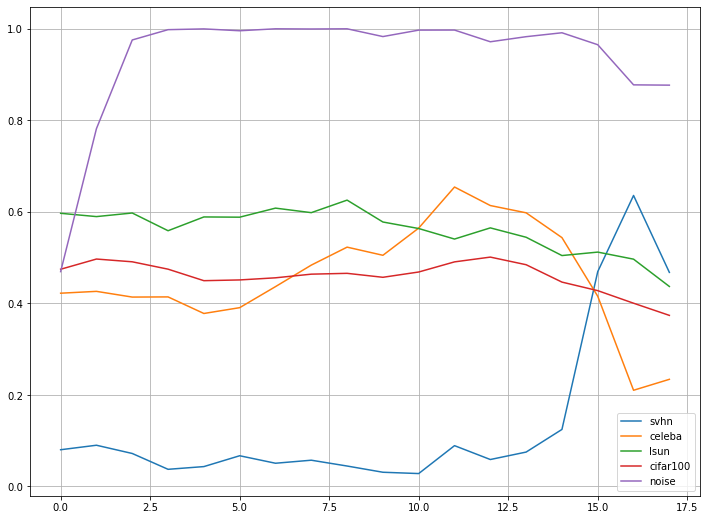

In [27]:
x = range(len(df.index))
fig = plt.figure(figsize=(12, 9))
for ood in df.columns:
    if ood not in ['mnist', 'fmnist', 'kmnist', 'omniglot', 'notmnist', 'constant']:
        plt.plot(x, df.loc[:, ood], label=ood)
plt.grid()
plt.legend()
plt.show()
fig.savefig('./temp.png')

# CNN-FMNIST

In [3]:
opt = config.CNN_fmnist
model = load_pretrained_CNN(option=opt.train_dist)
model.eval()

layers = {
    'conv1': model.layer1[0],
    'conv2': model.layer2[0],
    'conv3': model.layer3[0],
    'fc1': model.fc1,
    'conv4': model.layer4[0],
    'fc2': model.fc2,
}

In [5]:
a, b, _scores = AUTO_CNN(opt, model, layers, max_iter=[10000, 5000], method='Vanilla')

Calculate Fisher CNN:  50%|█████████████████████████▉                          | 4999/10000 [00:16<00:16, 308.22step/s]


Using downloaded and verified file: ../data\test_32x32.mat


Calculate Fisher CNN: 100%|█████████████████████████████████████████████████████| 3000/3000 [00:16<00:00, 176.47step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|█████████████████████████▉                          | 4999/10000 [00:17<00:17, 290.06step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|█████████████████████████▉                          | 4999/10000 [00:16<00:16, 306.72step/s]


Files already downloaded and verified


Calculate Fisher CNN:  50%|█████████████████████████▉                          | 4999/10000 [00:14<00:14, 336.08step/s]


In [6]:
for lname in layers.keys():
    FISHERs[opt.train_dist][lname] = a[lname] 
    NORM_FACs[opt.train_dist][lname] = b[lname]
for ood in opt.ood_list:
    SCOREs[opt.train_dist][ood] = _scores[ood]

# AUROC curve
auroc = {}
for lname in layers.keys():
    _auroc = {}
    for ood in opt.ood_list:
        args = [
            SCOREs[opt.train_dist][opt.train_dist][lname],
            SCOREs[opt.train_dist][ood][lname],
        ]
        labels = [opt.train_dist, ood]
        _auroc[ood] = AUROC(*args, labels=labels, verbose=False)
    auroc[lname] = _auroc
    
df = pd.DataFrame(auroc).T
df = df.iloc[:, 1:]
df

,svhn,celeba,lsun,cifar10,cifar100,mnist,kmnist,omniglot,notmnist,noise,constant
conv1,0.775341,0.744390,0.791949,0.774469,0.767601,0.587081,0.588806,0.796495,0.624263,0.619036,0.595314
conv2,0.628985,0.725461,0.753962,0.737778,0.732672,0.837455,0.862066,0.761549,0.734627,0.983552,0.541435
conv3,0.681535,0.844235,0.815000,0.797763,0.789628,0.933008,0.951465,0.874326,0.860421,0.969250,0.585096
fc1,0.934412,0.973320,0.965795,0.964545,0.961665,0.984879,0.990875,0.983450,0.980693,0.993000,0.890928
conv4,0.934412,0.973320,0.965795,0.964545,0.961665,0.984879,0.990875,0.983450,0.980693,0.993000,0.890928
fc2,0.983740,0.953875,0.974473,0.975952,0.974419,0.989653,0.974496,0.995277,0.981090,0.975603,0.954153


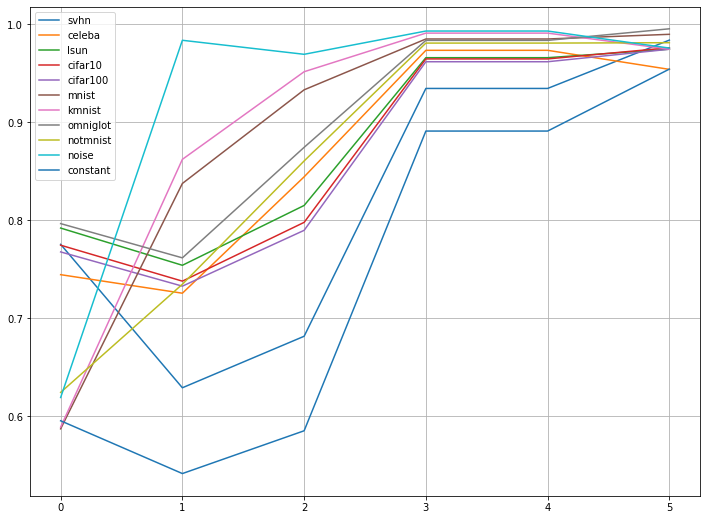

In [10]:
x = range(len(df.index))
fig = plt.figure(figsize=(12, 9))
for ood in df.columns:
    plt.plot(x, df.loc[:, ood], label=ood)
plt.grid()
plt.legend()
plt.show()
fig.savefig('./temp.png')

In [6]:
# Just show scores
# plot_scores_all_layers(train_dist, params, SCOREs, opt, save=True)
